In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import re
import seaborn as sns
from utils import pad_images
from model import RegressionModel
sns.set_palette('colorblind')
sns.set_style('darkgrid')
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # If using GPU
torch.backends.cudnn.benchmark = False    # If using GPU


# Read and Preprocess images

In [3]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 5037.43it/s]


In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [6]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
del padded_data
del data_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y
torch.cuda.empty_cache()

In [7]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=61, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Define the Regression Model
class RegressionModel(nn.Module):
    def __init__(self, num_classes=1):
        super(RegressionModel, self).__init__()
        self.resnet = models.resnet50()
        # Modify the first layer to accept 1 channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Mish(),
            nn.Linear(256, 64),
            nn.Mish(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        features = self.resnet(x)
        #output = self.linear_layers(features)
        return features

     

In [9]:
reg = RegressionModel()
reg.to(device)
X_train = []
y_train = []
for i in train_loader:
    X_train.extend(reg(i[0]).cpu().detach().numpy())
    y_train.extend(i[1].cpu().detach().numpy())

X_test = []
y_test = []
for i in test_loader:
    X_test.extend(reg(i[0]).cpu().detach().numpy())
    y_test.extend(i[1].cpu().detach().numpy())

In [10]:
del train_loader, test_loader
torch.cuda.empty_cache()

In [11]:
train_data = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train)).to(device=device, dtype=torch.float), torch.from_numpy(np.array(y_train)).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test)).to(device=device, dtype=torch.float), torch.from_numpy(np.array(y_test)).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, X_test, y_test, train_data, test_data
torch.cuda.empty_cache()





In [60]:
class MLP(nn.Module):
    def __init__(self, num_classes=1):
        super(MLP, self).__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Mish(),
            nn.Linear(512, 16),
            nn.Mish(),
            nn.Linear(16, num_classes),

        )

    def forward(self, x):
       # print (x.shape)
        features = self.linear_layers(x)
        #output = self.linear_layers(features)
        return features
    

In [63]:
import torch.optim as optim
mlp = MLP()
mlp.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0002500850964289255)
epochs = 350
train_losses = []

for epoch in range(epochs):
    for i in train_loader:
        out = mlp(i[0])
        loss = criterion(out, i[1].unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
        del out, loss
        torch.cuda.empty_cache()

yhat = []
y = []
for epoch in test_loader:
    out = mlp(epoch[0])
    loss = criterion(out, epoch[1].unsqueeze(1))
    yhat.append(out.cpu().detach().item())
    y.append(epoch[1].cpu().detach().item())

    del out, loss
    torch.cuda.empty_cache()

from sklearn.metrics import mean_squared_error
print (np.sqrt(mean_squared_error(y, yhat)))   


279.31170730173955


In [62]:
from sklearn.metrics import mean_squared_error
print (np.sqrt(mean_squared_error(y, yhat)))

276.63873430715057


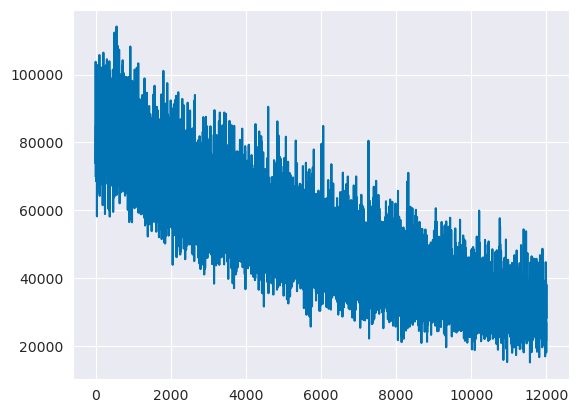

In [64]:
plt.plot(train_losses)

In [57]:
train_losses

[82033.140625]

In [ ]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
#create cross validation with k-fold
from sklearn.model_selection import StratifiedKFold
global skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
skf.get_n_splits(X, y)

In [7]:
import optuna

# Define a function to train and evaluate the model
def train(model, train_loader, lr, epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #train_losses = []
    for epoch in (range(epochs)):
        for images, targets in train_loader:
            model.train()
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), targets.float()) 
            loss.backward()
            optimizer.step()
    
    return model

def evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        
        y_true.extend(targets.tolist())
        
        if outputs.dim() == 2 and outputs.size(1) == 1:
            y_pred.extend(outputs.cpu().detach().squeeze(1).tolist())
        else:
            raise ValueError("Unexpected shape of 'outputs' tensor.")
        
    return y_true, y_pred

# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 25, 175)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
        del X_train, X_test, y_train, y_test, train_data, test_data
        torch.cuda.empty_cache()
    
    # Create and train the model
    model = RegressionModel().to(device)
    model = train(model, train_loader, lr, epochs)
    ytrue, yhat = evaluate(model, test_loader)
    
    return np.sqrt(mean_squared_error(ytrue, yhat))


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


In [10]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  35
Best trial:
Value:  11.20488665479658
Params: 
    lr: 0.0002500850964289255
    batch_size: 64
    epochs: 174


In [9]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

plot_optimization_history(study)

In [11]:
plot_param_importances(study)